In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paramaggarwal/fashion-product-images-small

100% 564M/565M [00:04<00:00, 51.4MB/s]
100% 565M/565M [00:04<00:00, 135MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fashion-product-images-small.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os

In [ ]:
DATASET_PATH = "/content/myntradataset"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [ ]:
df = pd.read_csv(DATASET_PATH + "/styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

<ipython-input-14-75c5b31b73f3>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(DATASET_PATH + "/styles.csv", nrows=5000, error_bad_lines=False)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [ ]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()

def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img):
    return cv2.imread(img_path(img))

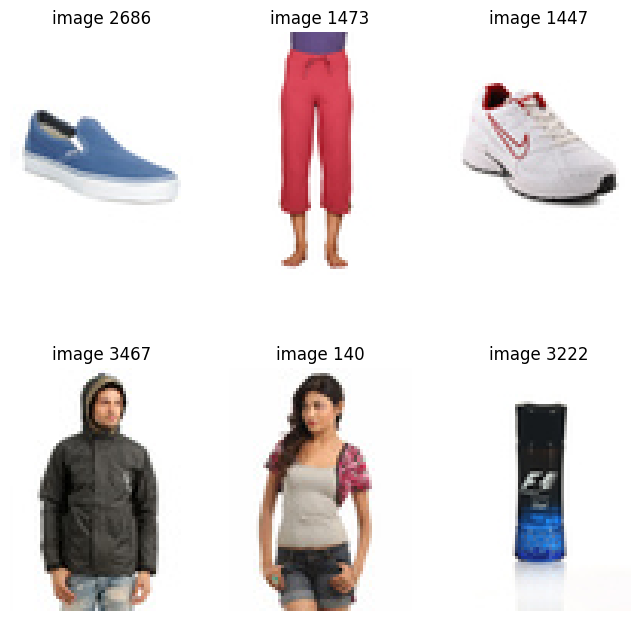

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'image '+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

<Axes: >

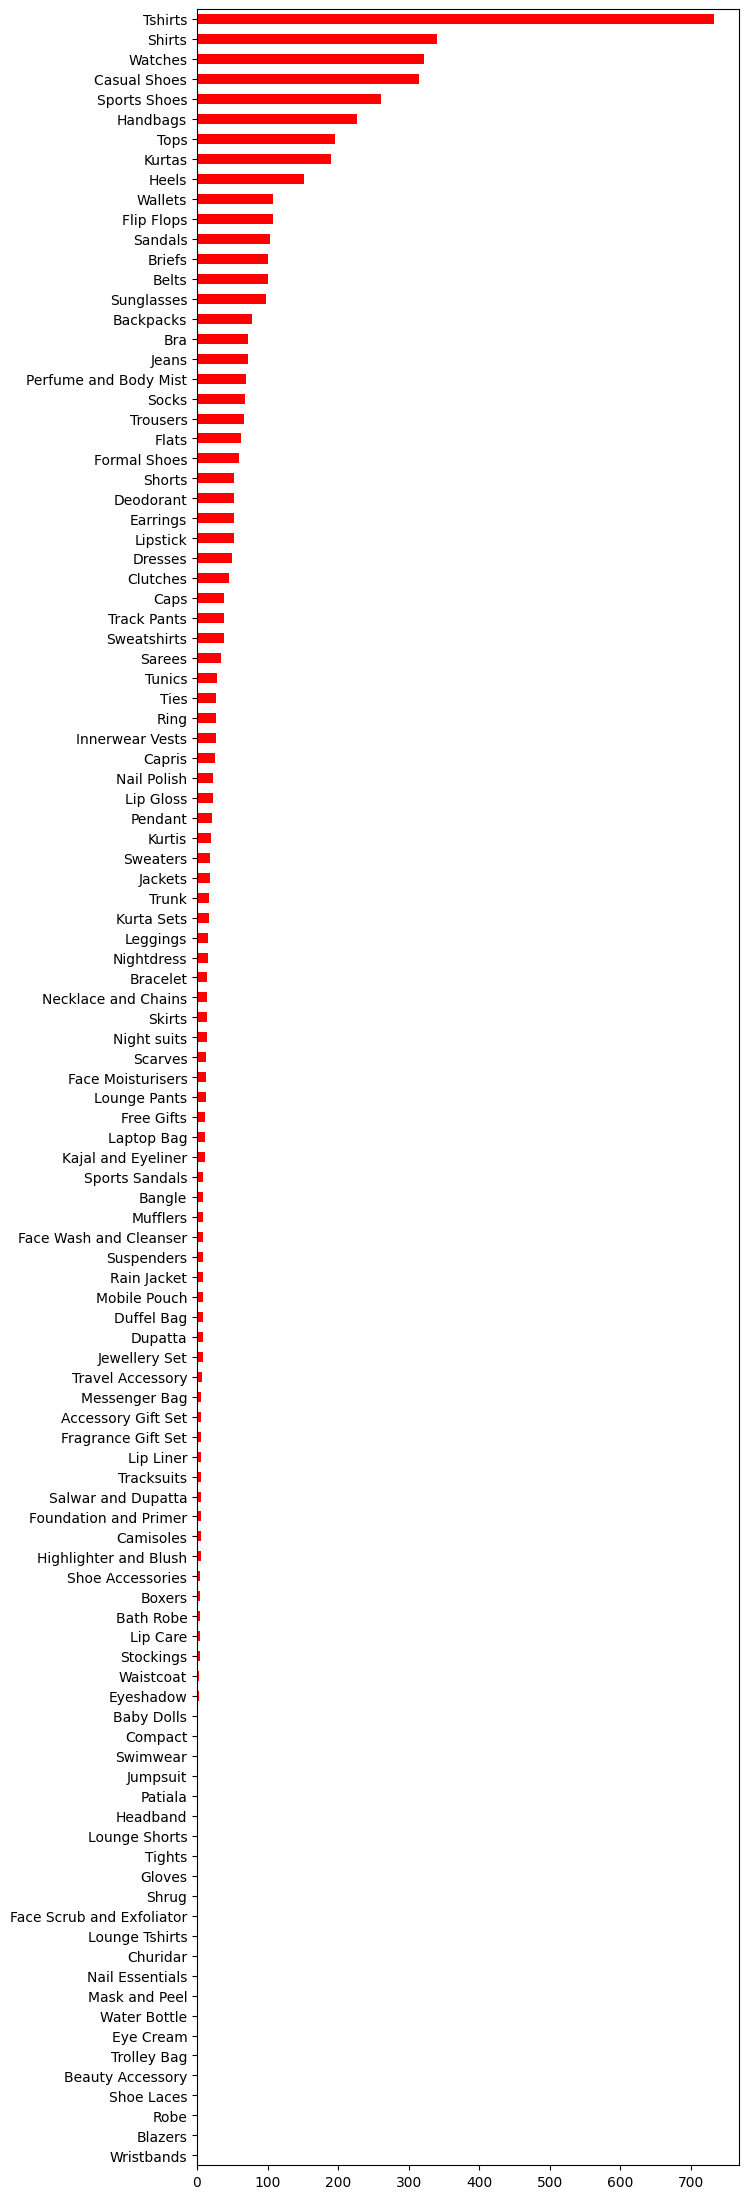

In [ ]:
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh',color='red')

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D

In [ ]:
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
resnet_model.trainable = False

model = tf.keras.Sequential([
    resnet_model,
    GlobalMaxPooling2D()
])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
img_width, img_height, _ = 224, 224, 3
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [ ]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 8s 8s/step


(2048,)

Enter any number for your choice:99
(80, 60, 3)
[ 2.2286482  6.7580295  0.        ...  2.485379   2.5894907 18.3445   ]


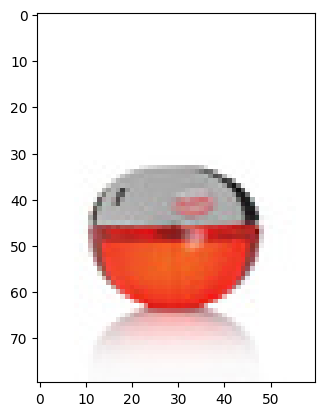

In [ ]:
x=int(input("Enter any number for your choice:"))
img_array = load_image(df.iloc[x].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [ ]:
df_sample= df
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
(5000, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.228648,6.758029,0.000000,1.157926,4.044765,4.190836,7.823343,8.598853,1.214275,0.000000,...,1.759048,5.455356,2.264872,22.648228,0.318426,0.000000,9.307659,2.485379,2.589491,18.344500
1,2.160761,13.004463,0.092262,6.950656,5.372196,0.000000,15.559416,2.178861,0.848540,0.146071,...,2.459636,8.469255,5.472929,8.990247,3.187693,0.256656,7.267739,0.000000,6.571843,17.669735
2,0.000000,2.099378,1.121325,5.048749,2.971081,4.301215,3.864703,1.902140,0.494964,4.596431,...,0.000000,16.961666,2.302287,1.838042,0.741321,0.000000,2.888047,2.204802,5.722492,6.089285
3,0.000000,5.336302,1.670130,11.411598,1.258602,0.000000,12.816574,7.772424,0.845026,2.947623,...,29.042683,1.647545,0.176537,0.000000,6.040611,1.806889,10.376257,0.000000,16.299801,16.499533
4,2.663739,15.295511,0.032791,2.476952,6.908776,2.586330,9.054916,7.316333,0.000000,0.000000,...,2.014325,6.502703,3.596586,19.685747,6.044677,0.000000,8.757939,2.212010,4.258547,17.862131


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.6364491 , 0.49602586, 0.59438896],
       [0.6364491 , 1.        , 0.509784  , 0.73752314],
       [0.49602586, 0.509784  , 1.        , 0.47131717],
       [0.59438896, 0.73752314, 0.47131717, 0.9999997 ]], dtype=float32)

Choose your id in between 0 to 4999:876


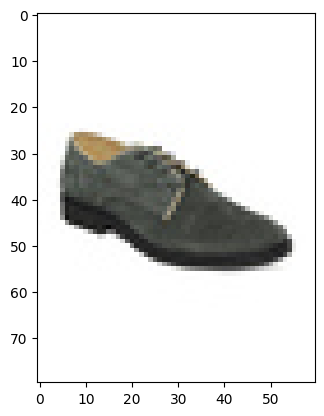

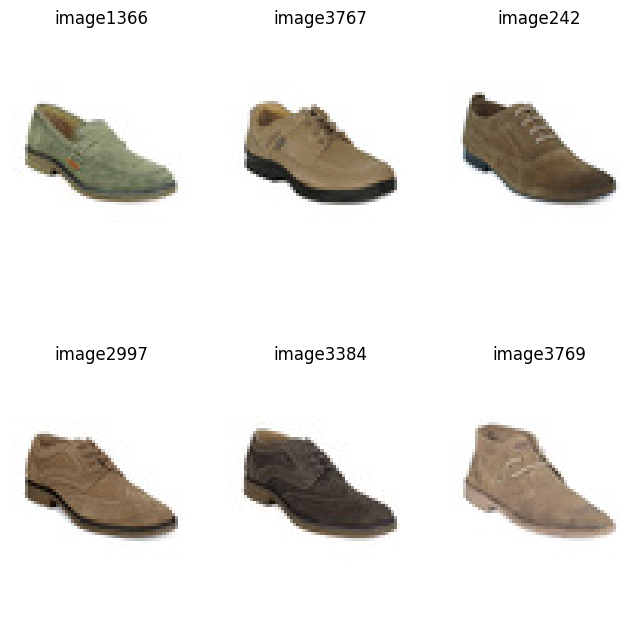

In [ ]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]

    return indices.iloc[idx_rec].index, idx_sim
n=int(input("Choose your id in between 0 to 4999:"))
get_recommender(n, df, top_n = 5)
# Idx Item to Recommender
idx_ref = n

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'image'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)
